In [ ]:
!git clone https://github.com/MannLabs/SPARCSpy.git

Cloning into 'SPARCSpy'...
remote: Enumerating objects: 1348, done.
remote: Counting objects: 100% (569/569), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 1348 (delta 481), reused 407 (delta 407), pack-reused 779 (from 1)
Receiving objects: 100% (1348/1348), 282.54 MiB | 8.44 MiB/s, done.
Resolving deltas: 100% (774/774), done.
Updating files:  92% (383/416)

In [ ]:
!cd SPARCSpy

In [1]:
!pip install tqdm


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [1]:
from sparcscore.ml.datasets import HDF5SingleCellDataset
#from sparcscore.ml.transforms import RandomRotation, GaussianNoise, ChannelReducer, ChannelSelector
#from sparcscore.ml.utils import combine_datasets_balanced
import h5py
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
!pwd

/mnt/c/Users/mahim/Documents/Thesis/sparc_env/Subset_screen_2.3


In [4]:
screen_data = HDF5SingleCellDataset(
    dir_list=['/mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin1/single_cells.h5'],
    dir_labels=[5], 
    root_dir='/mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/',
    select_channel=4,  # Select the 5th channel (channel index 4)
    return_id=True
)

Total: 19516
5: 19516


In [6]:
def inspect_hdf5_file(hdf5_path):
    with h5py.File(hdf5_path, "r") as hdf5_file:
        keys = list(hdf5_file.keys())
        print(f"Keys: {keys}\n")

        # Iterate over each key
        for key in keys:
            print(f"Key: {key}")
            dataset = hdf5_file[key]
            print(f" - Shape: {dataset.shape}")
            print(f" - Data type: {dataset.dtype}")
            
            # Print first 5 elements
            if len(dataset.shape) == 1:
                print(f" - Sample data: {dataset[:5]}")
            elif len(dataset.shape) == 2:
                print(f" - Sample data (first 5 rows): \n{dataset[:5, :]}")
            elif len(dataset.shape) == 3:
                print(f" - Sample data (first 5 rows, first channel): \n{dataset[:5, :, 0]}")
            print("\n")

# List of HDF5 file paths -> sneak a peak into all biol. class file types
hdf5_paths = ['/mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin1/single_cells.h5']

# Inspect each thing
for hdf5_path in hdf5_paths:
    print(f"Inspecting file: {hdf5_path}")
    inspect_hdf5_file(hdf5_path)
    print("=" * 160 + "\n")

Inspecting file: /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin1/single_cells.h5
Keys: ['annotation', 'single_cell_data', 'single_cell_index']

Key: annotation
 - Shape: (19516, 5)
 - Data type: object
 - Sample data (first 5 rows): 
[[b'166249' b'3854' b'2.3_A001' b'bin1' b'True']
 [b'202580' b'4331' b'2.3_A001' b'bin1' b'True']
 [b'461255' b'4786' b'2.3_A001' b'bin1' b'True']
 [b'66709' b'5035' b'2.3_A001' b'bin1' b'True']
 [b'150729' b'7719' b'2.3_A001' b'bin1' b'True']]


Key: single_cell_data
 - Shape: (19516, 5, 128, 128)
 - Data type: float16


Key: single_cell_index
 - Shape: (19516, 2)
 - Data type: uint64
 - Sample data (first 5 rows): 
[[     0 166249]
 [     1 202580]
 [     2 461255]
 [     3  66709]
 [     4 150729]]





### Create subset for each bin of bin 1 size

In [7]:
# Set random seed for reproducibility
np.random.seed(42)

# Set base path and number of cells from bin1
base_path = '/mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets'
target_n_cells = 10000
batch_size = 150  

# Bins to subset
bins = ['bin1', 'bin2', 'bin3', 'bin4', 'bin5', 'bin6']

for bin_name in bins:
    input_file = os.path.join(base_path, bin_name, 'single_cells.h5')
    output_file = os.path.join(base_path, bin_name, 'single_cells_subsetted.h5')

    with h5py.File(input_file, 'r') as infile:
        print(f"Processing {input_file}")

        total_cells = infile['single_cell_data'].shape[0]
        assert total_cells >= target_n_cells, f"{bin_name} has fewer than {target_n_cells} cells!"

        subset_indices = np.random.choice(total_cells, size=target_n_cells, replace=False)
        subset_indices.sort()

        # Create output file and preallocate datasets
        with h5py.File(output_file, 'w') as outfile:
            # Dataset properties
            sample_shape = infile['single_cell_data'].shape[1:]
            annotation_dtype = infile['annotation'].dtype
            index_dtype = infile['single_cell_index'].dtype
            image_dtype = infile['single_cell_data'].dtype

            # Preallocate
            dset_data = outfile.create_dataset(
                'single_cell_data',
                shape=(target_n_cells, *sample_shape),
                dtype=image_dtype
            )
            dset_annotation = outfile.create_dataset(
                'annotation',
                shape=(target_n_cells, infile['annotation'].shape[1]),
                dtype=annotation_dtype
            )
            dset_index = outfile.create_dataset(
                'single_cell_index',
                shape=(target_n_cells, 2),
                dtype=index_dtype
            )

            # Batched copy with progress bar
            for i in tqdm(range(0, target_n_cells, batch_size), desc=f"Subsetting {bin_name}"):
                batch_idx = subset_indices[i:i + batch_size]
                j = len(batch_idx)  # actual batch size (might be <100 at end)

                dset_data[i:i + j] = infile['single_cell_data'][batch_idx]
                dset_annotation[i:i + j] = infile['annotation'][batch_idx]
                dset_index[i:i + j] = infile['single_cell_index'][batch_idx]

    print(f"Saved subsetted file to {output_file}\n{'=' * 100}")

Processing /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin1/single_cells.h5


Subsetting bin1: 100%|██████████████████████████████████████████████████████████| 67/67 [03:06<00:00,  2.78s/it]


Saved subsetted file to /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin1/single_cells_subsetted.h5
Processing /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin2/single_cells.h5


Subsetting bin2: 100%|██████████████████████████████████████████████████████████| 67/67 [02:58<00:00,  2.66s/it]


Saved subsetted file to /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin2/single_cells_subsetted.h5
Processing /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin3/single_cells.h5


Subsetting bin3: 100%|██████████████████████████████████████████████████████████| 67/67 [02:54<00:00,  2.61s/it]


Saved subsetted file to /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin3/single_cells_subsetted.h5
Processing /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin4/single_cells.h5


Subsetting bin4: 100%|██████████████████████████████████████████████████████████| 67/67 [02:53<00:00,  2.59s/it]


Saved subsetted file to /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin4/single_cells_subsetted.h5
Processing /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin5/single_cells.h5


Subsetting bin5: 100%|██████████████████████████████████████████████████████████| 67/67 [02:53<00:00,  2.59s/it]


Saved subsetted file to /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin5/single_cells_subsetted.h5
Processing /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin6/single_cells.h5


Subsetting bin6: 100%|██████████████████████████████████████████████████████████| 67/67 [02:52<00:00,  2.57s/it]

Saved subsetted file to /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin6/single_cells_subsetted.h5


In [2]:
import os
import h5py
import numpy as np
from tqdm import tqdm

# Set base path and number of cells from each bin
base_path = '/mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets'
target_n_cells = 10000
batch_size = 200  

# Bins to subset
bins = ['bin1', 'bin2', 'bin3', 'bin4', 'bin5', 'bin6']

for bin_name in bins:
    input_file = os.path.join(base_path, bin_name, 'single_cells.h5')
    output_file = os.path.join(base_path, bin_name, 'single_cells_subsetted.h5')

    with h5py.File(input_file, 'r') as infile:
        print(f"Processing {input_file}")

        total_cells = infile['single_cell_data'].shape[0]
        assert total_cells >= target_n_cells, f"{bin_name} has fewer than {target_n_cells} cells!"

        #Select the first 10,000 cells deterministically
        subset_indices = np.arange(target_n_cells)

        # Create output file and preallocate datasets
        with h5py.File(output_file, 'w') as outfile:
            # Dataset properties
            sample_shape = infile['single_cell_data'].shape[1:]
            annotation_dtype = infile['annotation'].dtype
            index_dtype = infile['single_cell_index'].dtype
            image_dtype = infile['single_cell_data'].dtype

            # Preallocate
            dset_data = outfile.create_dataset(
                'single_cell_data',
                shape=(target_n_cells, *sample_shape),
                dtype=image_dtype
            )
            dset_annotation = outfile.create_dataset(
                'annotation',
                shape=(target_n_cells, infile['annotation'].shape[1]),
                dtype=annotation_dtype
            )
            dset_index = outfile.create_dataset(
                'single_cell_index',
                shape=(target_n_cells, 2),
                dtype=index_dtype
            )

            # Batched copy with progress bar
            for i in tqdm(range(0, target_n_cells, batch_size), desc=f"Subsetting {bin_name}"):
                batch_idx = subset_indices[i:i + batch_size]
                j = len(batch_idx)  # actual batch size (might be <150 at end)

                dset_data[i:i + j] = infile['single_cell_data'][batch_idx]
                dset_annotation[i:i + j] = infile['annotation'][batch_idx]
                dset_index[i:i + j] = infile['single_cell_index'][batch_idx]

    print(f"Saved subsetted file to: {output_file}\n{'=' * 100}")

Processing /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin1/single_cells.h5


Subsetting bin1: 100%|██████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


Saved subsetted file to: /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin1/single_cells_subsetted.h5
Processing /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin2/single_cells.h5


Subsetting bin2: 100%|██████████████████████████████████████████████████████████████████| 50/50 [01:08<00:00,  1.36s/it]


Saved subsetted file to: /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin2/single_cells_subsetted.h5
Processing /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin3/single_cells.h5


Subsetting bin3: 100%|██████████████████████████████████████████████████████████████████| 50/50 [01:16<00:00,  1.54s/it]


Saved subsetted file to: /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin3/single_cells_subsetted.h5
Processing /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin4/single_cells.h5


Subsetting bin4: 100%|██████████████████████████████████████████████████████████████████| 50/50 [01:11<00:00,  1.43s/it]


Saved subsetted file to: /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin4/single_cells_subsetted.h5
Processing /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin5/single_cells.h5


Subsetting bin5: 100%|██████████████████████████████████████████████████████████████████| 50/50 [01:17<00:00,  1.55s/it]


Saved subsetted file to: /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin5/single_cells_subsetted.h5
Processing /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin6/single_cells.h5


Subsetting bin6: 100%|██████████████████████████████████████████████████████████████████| 50/50 [01:30<00:00,  1.81s/it]

Saved subsetted file to: /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin6/single_cells_subsetted.h5


### Inspect resulting files and images

In [2]:
# Function to inspect HDF5 files
def inspect_hdf5_file(hdf5_path):
    with h5py.File(hdf5_path, "r") as hdf5_file:
        keys = list(hdf5_file.keys())
        print(f"Keys: {keys}\n")

        # Iterate over each key
        for key in keys:
            print(f"Key: {key}")
            dataset = hdf5_file[key]
            print(f" - Shape: {dataset.shape}")
            print(f" - Data type: {dataset.dtype}")
            
            # Print first 5 elements
            if len(dataset.shape) == 1:
                print(f" - Sample data: {dataset[:5]}")
            elif len(dataset.shape) == 2:
                print(f" - Sample data (first 5 rows): \n{dataset[:5, :]}")
            elif len(dataset.shape) == 3:
                print(f" - Sample data (first 5 rows, first channel): \n{dataset[:5, :, 0]}")
            print("\n")

In [3]:
# Function to plot images from HDF5 files
def plot_images_from_hdf5(hdf5_path):
    with h5py.File(hdf5_path, "r") as hdf5_file:
        # Assuming the 5th channel is the LC3 channel
        single_cell_data = hdf5_file['single_cell_data'][:]
        
        # Select the first 4 images (adjust if the dataset is smaller)
        for i in range(min(4, single_cell_data.shape[0])):
            fig, ax = plt.subplots(figsize=(6, 6))
            # The 5th channel corresponds to index 4 (0-based indexing)
            ax.imshow(single_cell_data[i, :, :, 4], cmap='viridis')  # Channel 5 (LC3)
            ax.set_title(f"Image {i + 1} - LC3 Channel")
            ax.axis('off')
            plt.show()

Inspecting file: /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin1/single_cells.h5
Keys: ['annotation', 'single_cell_data', 'single_cell_index']

Key: annotation
 - Shape: (19516, 5)
 - Data type: object
 - Sample data (first 5 rows): 
[[b'166249' b'3854' b'2.3_A001' b'bin1' b'True']
 [b'202580' b'4331' b'2.3_A001' b'bin1' b'True']
 [b'461255' b'4786' b'2.3_A001' b'bin1' b'True']
 [b'66709' b'5035' b'2.3_A001' b'bin1' b'True']
 [b'150729' b'7719' b'2.3_A001' b'bin1' b'True']]


Key: single_cell_data
 - Shape: (19516, 5, 128, 128)
 - Data type: float16


Key: single_cell_index
 - Shape: (19516, 2)
 - Data type: uint64
 - Sample data (first 5 rows): 
[[     0 166249]
 [     1 202580]
 [     2 461255]
 [     3  66709]
 [     4 150729]]



Plotting images for file: /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin1/single_cells.h5


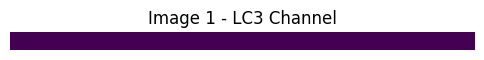

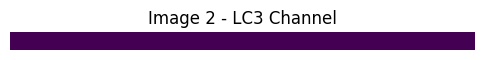

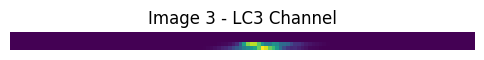

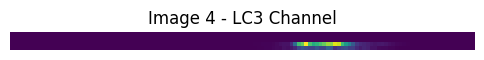


Inspecting file: /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin2/single_cells_subsetted.h5
Keys: ['annotation', 'single_cell_data', 'single_cell_index']

Key: annotation
 - Shape: (19516, 5)
 - Data type: object
 - Sample data (first 5 rows): 
[[b'331484' b'349' b'2.3_A001' b'bin2' b'True']
 [b'11442' b'516' b'2.3_A001' b'bin2' b'True']
 [b'53377' b'777' b'2.3_A001' b'bin2' b'True']
 [b'209980' b'2334' b'2.3_A001' b'bin2' b'True']
 [b'195789' b'3664' b'2.3_A001' b'bin2' b'True']]


Key: single_cell_data
 - Shape: (19516, 5, 128, 128)
 - Data type: float16


Key: single_cell_index
 - Shape: (19516, 2)
 - Data type: uint64
 - Sample data (first 5 rows): 
[[     4 331484]
 [     6  11442]
 [    12  53377]
 [    24 209980]
 [    33 195789]]



Plotting images for file: /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin2/single_cells_subsetted.h5


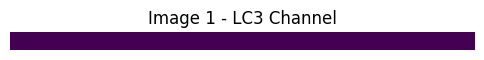

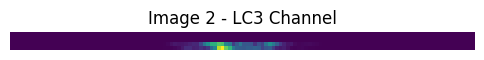

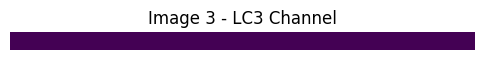

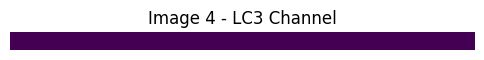


Inspecting file: /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin3/single_cells_subsetted.h5
Keys: ['annotation', 'single_cell_data', 'single_cell_index']

Key: annotation
 - Shape: (19516, 5)
 - Data type: object
 - Sample data (first 5 rows): 
[[b'401456' b'1767' b'2.3_A001' b'bin3' b'True']
 [b'226432' b'1973' b'2.3_A001' b'bin3' b'True']
 [b'70773' b'3339' b'2.3_A001' b'bin3' b'True']
 [b'405087' b'3552' b'2.3_A001' b'bin3' b'True']
 [b'58079' b'6005' b'2.3_A001' b'bin3' b'False']]


Key: single_cell_data
 - Shape: (19516, 5, 128, 128)
 - Data type: float16


Key: single_cell_index
 - Shape: (19516, 2)
 - Data type: uint64
 - Sample data (first 5 rows): 
[[     0 401456]
 [     2 226432]
 [     7  70773]
 [     8 405087]
 [    13  58079]]



Plotting images for file: /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin3/single_cells_subsetted.h5


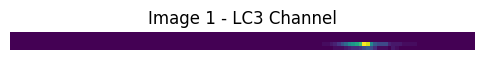

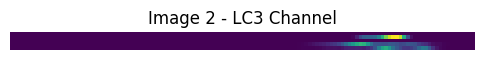

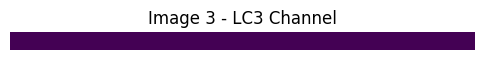

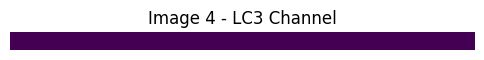


Inspecting file: /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin4/single_cells_subsetted.h5
Keys: ['annotation', 'single_cell_data', 'single_cell_index']

Key: annotation
 - Shape: (19516, 5)
 - Data type: object
 - Sample data (first 5 rows): 
[[b'49245' b'1244' b'2.3_A001' b'bin4' b'False']
 [b'352336' b'1805' b'2.3_A001' b'bin4' b'True']
 [b'259954' b'2857' b'2.3_A001' b'bin4' b'False']
 [b'78984' b'3717' b'2.3_A001' b'bin4' b'True']
 [b'403468' b'3809' b'2.3_A001' b'bin4' b'False']]


Key: single_cell_data
 - Shape: (19516, 5, 128, 128)
 - Data type: float16


Key: single_cell_index
 - Shape: (19516, 2)
 - Data type: uint64
 - Sample data (first 5 rows): 
[[     2  49245]
 [     3 352336]
 [     7 259954]
 [    10  78984]
 [    11 403468]]



Plotting images for file: /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin4/single_cells_subsetted.h5


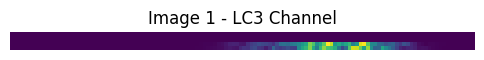

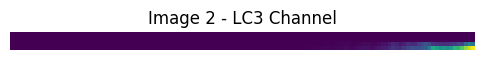

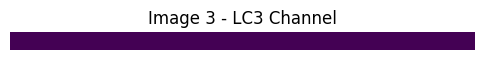

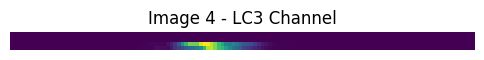


Inspecting file: /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin5/single_cells_subsetted.h5
Keys: ['annotation', 'single_cell_data', 'single_cell_index']

Key: annotation
 - Shape: (19516, 5)
 - Data type: object
 - Sample data (first 5 rows): 
[[b'58163' b'4114' b'2.3_A001' b'bin5' b'True']
 [b'167757' b'8122' b'2.3_A001' b'bin5' b'True']
 [b'137375' b'10336' b'2.3_A001' b'bin5' b'False']
 [b'59897' b'11026' b'2.3_A001' b'bin5' b'True']
 [b'13961' b'12494' b'2.3_A001' b'bin5' b'True']]


Key: single_cell_data
 - Shape: (19516, 5, 128, 128)
 - Data type: float16


Key: single_cell_index
 - Shape: (19516, 2)
 - Data type: uint64
 - Sample data (first 5 rows): 
[[     9  58163]
 [    16 167757]
 [    22 137375]
 [    25  59897]
 [    26  13961]]



Plotting images for file: /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin5/single_cells_subsetted.h5


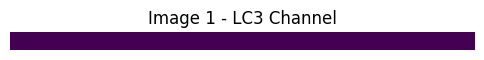

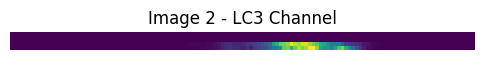

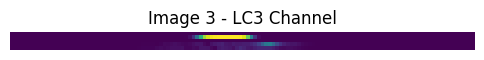

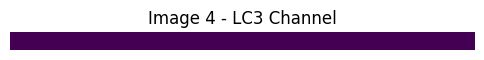


Inspecting file: /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin6/single_cells_subsetted.h5
Keys: ['annotation', 'single_cell_data', 'single_cell_index']

Key: annotation
 - Shape: (19516, 5)
 - Data type: object
 - Sample data (first 5 rows): 
[[b'177884' b'467' b'2.3_A001' b'bin6' b'True']
 [b'49649' b'3589' b'2.3_A001' b'bin6' b'False']
 [b'387800' b'4311' b'2.3_A001' b'bin6' b'True']
 [b'256806' b'4505' b'2.3_A001' b'bin6' b'True']
 [b'136039' b'4863' b'2.3_A001' b'bin6' b'False']]


Key: single_cell_data
 - Shape: (19516, 5, 128, 128)
 - Data type: float16


Key: single_cell_index
 - Shape: (19516, 2)
 - Data type: uint64
 - Sample data (first 5 rows): 
[[     0 177884]
 [     5  49649]
 [     6 387800]
 [     7 256806]
 [     8 136039]]



Plotting images for file: /mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin6/single_cells_subsetted.h5


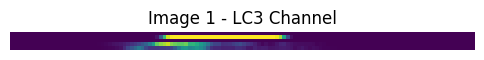

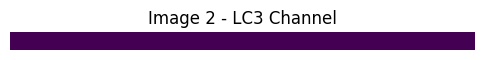

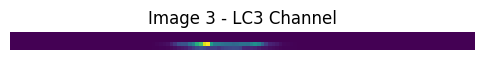

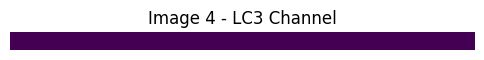

In [5]:
# List of HDF5 file paths (those that were subsetted)
hdf5_paths = [
    '/mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin1/single_cells.h5',
    '/mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin2/single_cells_subsetted.h5',
    '/mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin3/single_cells_subsetted.h5',
    '/mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin4/single_cells_subsetted.h5',
    '/mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin5/single_cells_subsetted.h5',
    '/mnt/c/Users/mahim/Documents/Thesis/single_cell_image_datasets/single_cell_image_datasets/bin6/single_cells_subsetted.h5'
]

# Inspect and plot each file
for hdf5_path in hdf5_paths:
    print(f"Inspecting file: {hdf5_path}")
    inspect_hdf5_file(hdf5_path)
    print("=" * 160 + "\n")
    
    print(f"Plotting images for file: {hdf5_path}")
    plot_images_from_hdf5(hdf5_path)
    print("=" * 160 + "\n")